In [213]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import pickle
import warnings 
import datetime
from datetime import timedelta

warnings.filterwarnings('ignore')

In [214]:
df = pd.read_csv('temp.csv', sep = ';') #, parse_dates=['Date'])

In [215]:
df.columns

Index(['Id', 'CityId', 'Date', 'Day temperature', 'Evening temperature'], dtype='object')

In [651]:
df_yfa = df[df.CityId == 7] # УФА

In [217]:
#df_yfa['Date']=  pd.to_datetime(df_yfa['Date']);

In [218]:
df_yfa.sort_values(by=['Date'])

,Id,CityId,Date,Day temperature,Evening temperature
527,527,7,2022/10/1,9.0,5.0
536,536,7,2022/10/10,17.0,7.0
537,537,7,2022/10/11,11.0,9.0
538,538,7,2022/10/12,16.0,9.0
539,539,7,2022/10/13,11.0,8.0
...,...,...,...,...,...
309,309,7,2023/3/4,0.0,-1.0
310,310,7,2023/3/5,0.0,1.0
311,311,7,2023/3/6,-1.0,-2.0
312,312,7,2023/3/7,-2.0,-3.0


In [219]:
df_yfa = df_yfa.sort_values(by=['Date'])

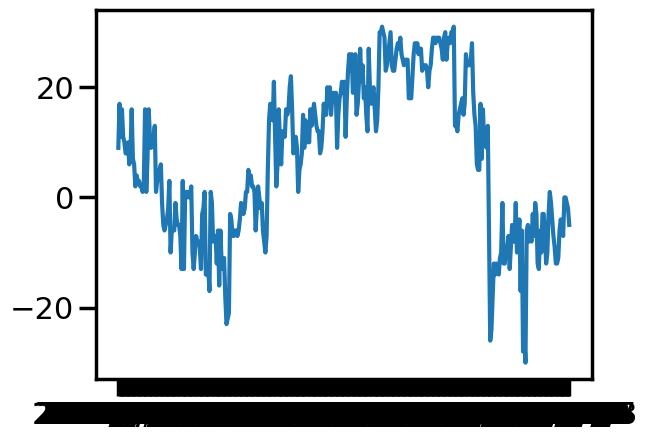

In [527]:
plt.plot(df_yfa['Date'], df_yfa['Day temperature'])

In [221]:
df_yfa['Day temperature'] = df_yfa['Day temperature'].fillna(27)

In [31]:
import numpy as np

In [32]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):

        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
    

In [33]:
n_steps = 7
X, y = split_sequence(df_yfa['Day temperature'].values, n_steps)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2 ,random_state=1, shuffle = False)

In [627]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('MLP', MLPRegressor(max_iter=2000, activation='identity',
                                                                    hidden_layer_sizes=(100,1) ,shuffle = False)) ])

In [628]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('MLP',
                 MLPRegressor(activation='identity',
                              hidden_layer_sizes=(100, 1), max_iter=2000,
                              shuffle=False))])

In [629]:
pickle.dump(pipe, open('pipe.pkl', 'wb'))

In [630]:
pickled_model = pickle.load(open('pipe.pkl', 'rb'))

In [631]:
X, y = split_sequence(df_yfa['Day temperature'].values, n_steps)

In [636]:
ids = 2
df_0 = df[df.CityId == ids]
X1, y1 = split_sequence(df_0['Day temperature'].values, n_steps)

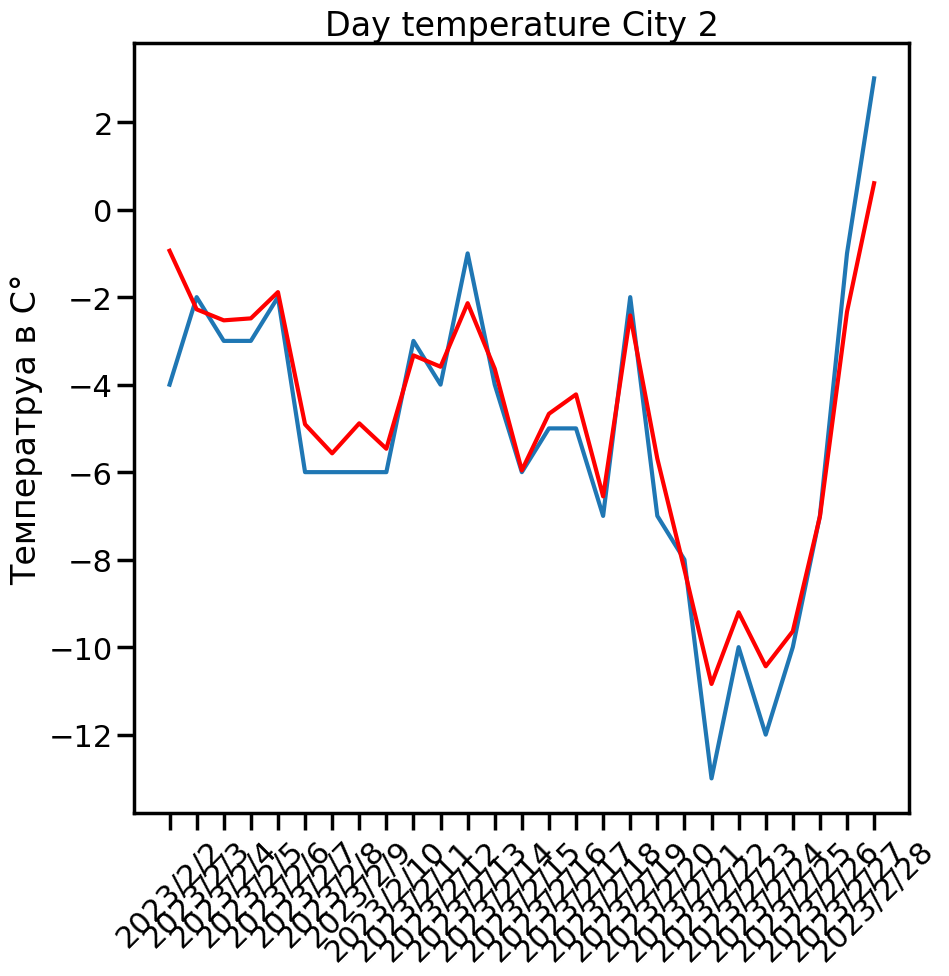

In [637]:
plt.figure(figsize = (10, 10))
plt.plot(df_0.Date[8:], np.roll(y1, 2)[1:])
plt.plot(df_0.Date[8:], pipe.predict(np.nan_to_num( X1, nan=np.nanmean(y1)))[:-1], color = 'red');
plt.tick_params(axis = 'x' , labelrotation = 45)
plt.ylabel('Температруа в C°')
plt.title(f'Day temperature City {ids}');

In [638]:
X1, y1 = split_sequence(df_0['Evening temperature'].values, n_steps)

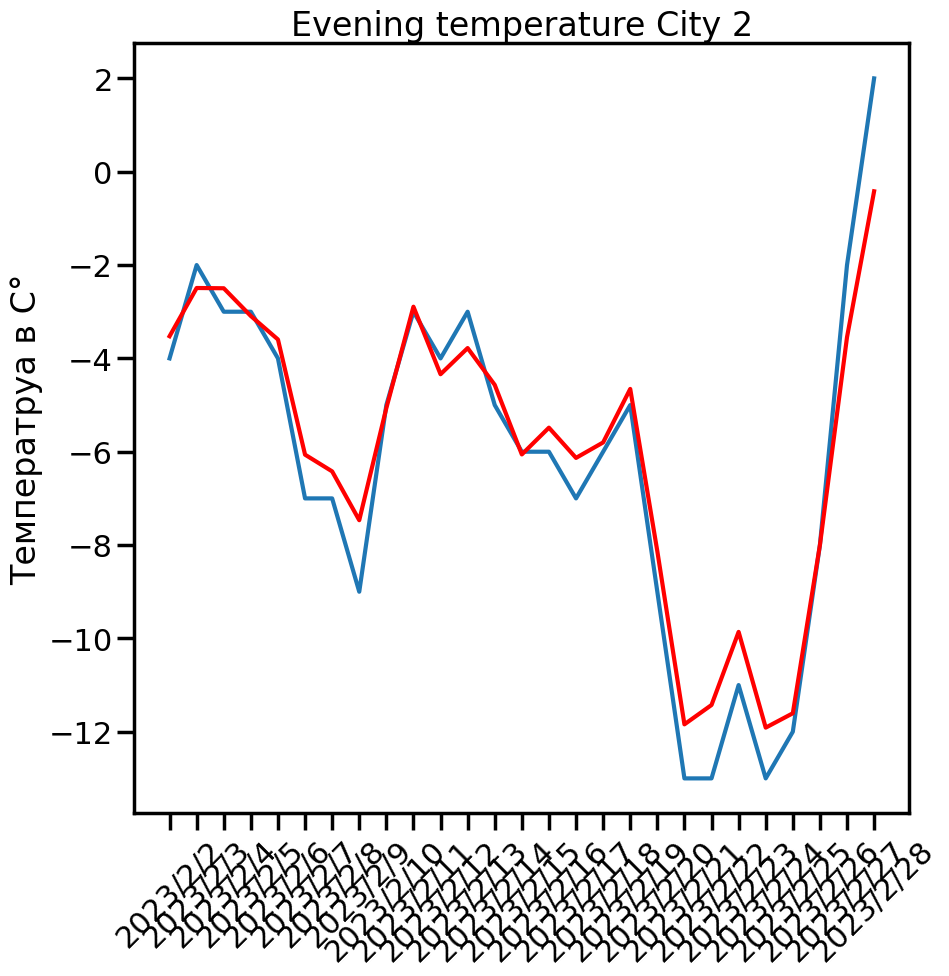

In [639]:
plt.figure(figsize = (10, 10))
plt.plot(df_0.Date[8:], np.roll(y1, 2)[1:])
plt.plot(df_0.Date[8:], pipe.predict(np.nan_to_num( X1, nan=np.nanmean(y1)))[:-1], color = 'red');
plt.tick_params(axis = 'x' , labelrotation = 45)
plt.ylabel('Температруа в C°')
plt.title(f'Evening temperature City {ids}');

In [640]:
def forecast(weather, days = 7):
    weather = np.array(weather)
    pred = []
    for i in range(days):
        predi = pipe.predict(weather.reshape(1,-1))
        weather = np.append(weather, predi)
        pred.append(predi[0])
        weather = np.delete(weather, 0 )
    
    return pred

In [641]:
def db_str_to_datetime_str(str_date : str):
        splitted_str = str_date.split('/')
        for i in range(len(splitted_str)):
            splitted_str[i] = f"{int(splitted_str[i]):02}"

        return '/'.join(splitted_str)

def db_str_to_datetime( str_date : str):
        datetime_str = db_str_to_datetime_str(str_date)
        return datetime.datetime.strptime(datetime_str, '%Y/%m/%d')

In [642]:
day_true = [db_str_to_datetime(f'2023/10/{i+1}')for i in range(7)] # синтетика

In [647]:
temp_true = [-2, -2, +1, +1, -1, -1, +1] # синтетика

In [648]:
predict = forecast(mos) # прогноз на синтетике

In [649]:
def plot_weather(days_true, weather_true, weather_pred, city_name): 
    
    last = days_true[-1] # последняя дата для непрерывного графика
    days_pred = [last] #  
    weather_pred.insert(0, weather_true[-1]) # добавить в прогнозы последнее значение для непрерывного графика
    for i in range(len(weather_pred)-1):
        days_pred.append(last + timedelta(1))
        last = days_pred[-1]
    
    
    sns.set_context("poster")
    plt.figure(figsize = (15, 15))
    plt.title(f'{city_name}')
    
    sns.lineplot(x = days_true, y = weather_true)
    sns.lineplot(x = days_pred, y = weather_pred, color = 'red', label = 'Прогноз')
    plt.xlabel('Дата')
    plt.ylabel('Температруа в C°')
    plt.tick_params(axis = 'x' , labelrotation = 45)
    plt.show;

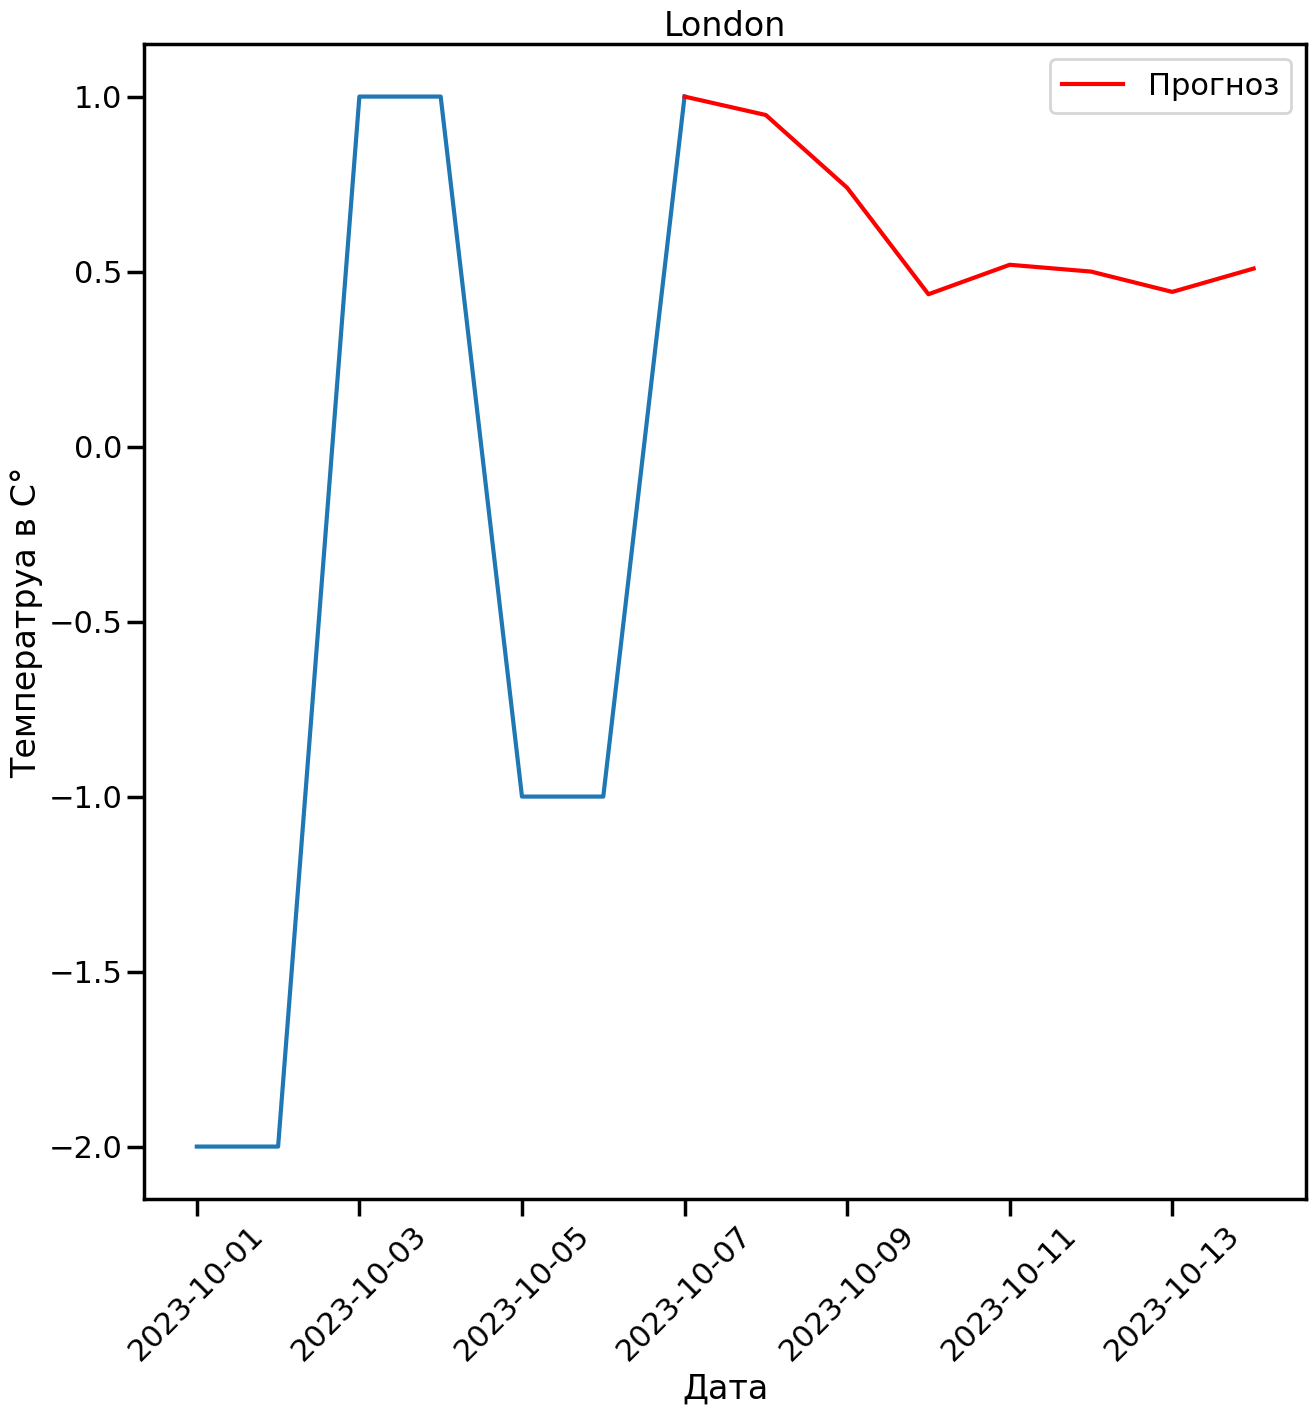

In [650]:
plot_weather(day_true, temp_true, predict.copy(), 'London') # даты, темп в даты, прогнозы, город
# дневной прогноз